<a href="https://colab.research.google.com/github/tanakakao/studymemo/blob/main/vit_keras_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NameError: ignored

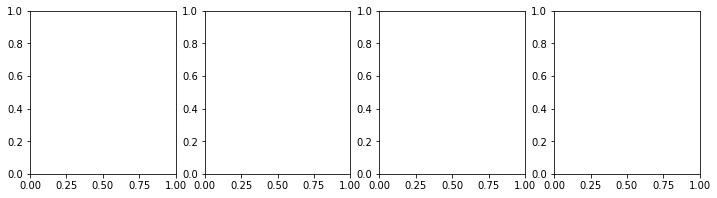

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Input, Dense, Conv1D, Conv2D, Activation, Dropout, LayerNormalization, Reshape, MultiHeadAttention, RepeatVector, Concatenate
from tensorflow.keras import activations
from tensorflow.keras.optimizers import RMSprop, Adagrad, Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
 
from keras import backend as K

import numpy as np
import pandas as pd
import math
import time

import matplotlib.pyplot as plt
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import cv2

# データセットの読み込み
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# バッチサイズ、クラス数、エポック数の設定
#batch_size=32
#num_classes=10
#epochs=5

# データリサイズ
#img_rows=224
#img_cols=224

#x_train = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_train[::5,:,:,:]])
#x_test = np.array([cv2.resize(img, (img_rows,img_cols)) for img in x_test[::5,:,:,:]])

# データ正規化
#x_train=x_train.astype('float32')
#x_train/=255
#x_test=x_test.astype('float32')
#x_test/=255

# one-hotベクトル化
#y_train = y_train[::5]
#y_test = y_test[::5]
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

fig, axes = plt.subplots(1, 4, figsize=(12,3))
[axes[i].imshow(x_train[i]) for i in range(4)];

In [ ]:
import os
print(len(os.listdir("/content/drive/MyDrive/PetImages/train/Dog")))
print(len(os.listdir("/content/drive/MyDrive/PetImages/train/Cat")))
print(len(os.listdir("/content/drive/MyDrive/PetImages/val/Dog")))
print(len(os.listdir("/content/drive/MyDrive/PetImages/val/Cat")))
print(len(os.listdir("/content/drive/MyDrive/PetImages/test/Dog")))
print(len(os.listdir("/content/drive/MyDrive/PetImages/test/Cat")))

7000
7000
3000
3000
621
2396


In [ ]:
import shutil
import os

#!unzip kagglecatsanddogs_5340.zip
#!cp -rp "PetImages" "/content/drive/My Drive/"

unzip:  cannot find or open kagglecatsanddogs_5340.zip, kagglecatsanddogs_5340.zip.zip or kagglecatsanddogs_5340.zip.ZIP.
cp: cannot stat 'PetImages': No such file or directory


In [ ]:
os.makedirs('/content/drive/MyDrive/PetImages/train/Dog', exist_ok=True)
os.makedirs('/content/drive/MyDrive/PetImages/train/Cat', exist_ok=True)
os.makedirs('/content/drive/MyDrive/PetImages/val/Dog', exist_ok=True)
os.makedirs('/content/drive/MyDrive/PetImages/val/Cat', exist_ok=True)
os.makedirs('/content/drive/MyDrive/PetImages/test/Dog', exist_ok=True)
os.makedirs('/content/drive/MyDrive/PetImages/test/Cat', exist_ok=True)

In [ ]:

for i in range(12001,13001)[::-1]:
  try:
    shutil.move("/content/drive/MyDrive/PetImages/Cat/"+str(i)+".jpg", '/content/drive/MyDrive/PetImages/test/Cat')
  except:
    continue
  try:
    shutil.move("/content/drive/MyDrive/PetImages/Dog/"+str(i)+".jpg", '/content/drive/MyDrive/PetImages/test/Dog')
  except:
    continue
  #if len(os.listdir("/content/drive/MyDrive/PetImages/val/Dog"))==3000:
  #  break

In [9]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Input, Dense, Conv1D, Conv2D, Activation, Dropout, LayerNormalization, Reshape, RepeatVector, Concatenate
from tensorflow.keras import activations
from tensorflow.keras.optimizers import RMSprop, Adagrad, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
 
from keras import backend as K

import numpy as np
import pandas as pd
import math
import time

import matplotlib.pyplot as plt
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import cv2

In [ ]:
class patch_embbeding(Layer):
    def __init__(self, img_size, patch_size=4, hidden_dim=8):
        super().__init__()
        self.D = hidden_dim
        
        self.patch_conv = Conv2D(filters = hidden_dim, kernel_size = (patch_size,patch_size), strides=patch_size, padding = 'same', activation='gelu')
        
        # [class]追加
        self.cls_token = self.add_weight(
            shape=(1,1,hidden_dim), initializer="random_normal", trainable=True, name='class', dtype=tf.float32
        )

        # position encoding
        self.position = self.add_weight(
            shape=(int(img_size[0]*img_size[1]/(patch_size*patch_size))+1,self.D), initializer="random_normal", trainable=True, name='position', dtype=tf.float32
        )
        
        self.repeat = RepeatVector
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        out = self.patch_conv(inputs)
        out = Reshape((-1,self.D))(out)
        cls = tf.broadcast_to(self.cls_token, [batch_size, 1, self.D])
        out = Concatenate(axis=1)([cls, out])
        out = out+self.position 
        return out

class SelfMultiHeadAttention(Layer):
    '''
    Multi-Head Attentionレイヤ

    model = MultiheadAttention(
        hidden_dim = 512,
        head_num = 8,
        drop_rate = 0.5
    )
    '''
    def __init__(self, hidden_dim, heads_num, drop_rate=0.5):
        '''
        Multi-Head Attentionレイヤ
    
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : マルチヘッドAttentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''

        super(SelfMultiHeadAttention, self).__init__()
        # 入力の線形変換
        # 重み行列は[hidden_dim, hidden_dim]
        self.query = Conv1D(hidden_dim, kernel_size=1)
        self.key   = Conv1D(hidden_dim, kernel_size=1)
        self.value = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力の線形変換
        self.projection = Conv1D(hidden_dim, kernel_size=1)
        
        # 出力のDropout
        self.drop = Dropout(drop_rate)
        
        self.nf = hidden_dim
        self.nh = heads_num
    
    def atten(self, query, key, value, attention_mask, training):
        """
        Attention
        
        query, key, value : クエリ、キー、バリュー
            query [batch_size, head_num, q_length, hidden_dim//head_num]
            key, value [batch_size, head_num, m_length, hidden_dim//head_num]
            ただし、encoder:q_length=m_length
                   decoder:mask multihead attentionではq_length=m_length
                           2つ目のmultihead attentionではq_length≠m_length
        attention_mask : attention weight に適用される mask
            encoder : [1, 1, q_length, q_length]
            decoder : [1, 1, m_length, m_length]
        """
        # 各値を取得
        shape = query.shape.as_list() # batch_size, head_num, q_length, hidden_dim//head_num
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[2] # トークン列数(q_length)
        hidden_dim = shape[1]*shape[3] # 特徴ベクトルの長さ(head_num × hidden_dim//head_num = hidden_dim)
        
        # ここで q と k の内積を取ることで、query と key の単語間の関連度のようなものを計算します。
        # tf.matmulで最後の2成分について積を計算(それ以外は形がそろっている必要あり)
        # transpose_bで転置
        # [batch_size, head_num, q_length, hidden_dim/head_num] @ [batch_size, head_num, hidden_dim/head_num, m_length] = [batch_size, head_num, q_length, m_length]
        scores = tf.matmul(query, key, transpose_b=True)
        
        # scoreをhidden_dimの平方根割る
        scores = tf.multiply(scores, tf.math.rsqrt(tf.cast(hidden_dim, tf.float32)))
        
        # Attention Maskがあればscoreに加算
        # attention_mask: [1, 1, (q|m)_length, (q|m)_length] 
        # マスク(参照しない部分)の場所に1、使用する部分は0とする
        # 1の部分を -無限大にする(softmax(-無限大)=0となる)
        # 1. PADを無視
        # 2. DecoderのSelf-Attentionで未来の情報を参照できないようにする
        if attention_mask is not None:
            scores = scores + attention_mask * -1e9
        # softmax を取ることで正規化します
        # input(query) の各単語に対して memory(key) の各単語のどこから情報を引いてくるかの重み
        atten_weight = tf.nn.softmax(scores, axis=-1)
        
        # 重みに従って value から情報を引いてきます
        # [batch_size, head_num, q_length, m_length] @ [batch_size, head_num, m_length, hidden_dim/head_num] = [batch_size, head_num, q_length, hidden_dim/head_num]
        # input(query) の単語ごとに memory(value)の各単語 に attention_weight を掛け合わせて足し合わせた ベクトル(分散表現の重み付き和)を計算
        context = tf.matmul(atten_weight, value)
        
        # 各ヘッドの結合(reshape)
        # 入力と同じ形に変換する
        # [batch_size, head_num, q_length, hidden_dim/head_num] -> [batch_size, q_length, head_num, hidden_dim/head_num]
        context = tf.transpose(context, [0, 2, 1, 3])
        # [batch_size, q_length, head_num, hidden_dim/head_num] -> [batch_size, q_length, hidden_dim]
        context = tf.reshape(context, (batch_size, token_num, hidden_dim))
        
        # 線形変換
        context = self.projection(context, training=training)
        
        return self.drop(context, training=training), atten_weight

    def _split(self, x):
        """
        query, key, valueを分割する
        
        入力 shape: [batch_size, length, hidden_dim]
        出力 shape: [batch_size, head_num, length, hidden_dim//head_num]
        """
        # 各値を取得
        hidden_dim = self.nf
        heads_num = self.nh
        shape = x.shape.as_list()
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[1] # トークン列数
        
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, (q|m)_length, head_num, hidden_dim/head_num]
        # splitだが実際は次元を拡張する処理
        x = tf.reshape(x, (batch_size, token_num, heads_num, int(hidden_dim/heads_num)))
        
        # [batch_size, (q|m)_length, head_num, hidden_dim/head_num] -> [batch_size, head_num, (q|m)_length, hidden_dim/head_num]
        x = tf.transpose(x, [0, 2, 1, 3])
        return x
    
    def call(self, x, training, memory, attention_mask=None, return_attention_scores=False):
        """
        モデルの実行
        
        input : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        """
        # memoryが入力されない場合、memory=input(Self Attention)とする
        if memory is None:
            memory = x

        # input -> query
        # memory -> key, value
        # [batch_size, (q|m)_length, hidden_dim] @ [hidden_dim, hidden_dim] -> [batch_size, (q|m)_length, hidden_dim] 
        query = self.query(x)
        key = self.key(memory)
        value = self.value(memory)
        
        # ヘッド数に分割する
        # 実際はreshapeで次数を1つ増やす
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, head_num, (q|m)_length, hidden_dim/head_num]
        query = self._split(query)
        key = self._split(key)
        value = self._split(value)
        
        # attention
        # 入力と同じ形の出力
        # context: [batch_size, q_length, hidden_dim]
        # score_weightsはEncoderではNoneとする
        context, attn_weights = self.atten(query, key, value, attention_mask, training)
        if not return_attention_scores:
            return context
        else:
            return context, attn_weights

class FeedForwardNetwork(Layer):
    '''
    Position-wise Feedforward Neural Network
    transformer blockで使用される全結合層
    '''
    def __init__(self, hidden_dim, drop_rate):
        '''
        hidden_dim : Embeddingされた単語ベクトルの長さ
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        # 2層構造
        # 1層目：チャンネル数を増加させる
        self.filter_dense_layer = Dense(hidden_dim * 4, use_bias=True, activation='gelu')
        
        # 2層目：元のチャンネル数に戻す
        self.output_dense_layer = Dense(hidden_dim, use_bias=True)
        self.drop = Dropout(drop_rate)

    def call(self, x, training):
        '''
        入力と出力で形が変わらない
        x : 入力 [batch_size, length, hidden_dim]
        '''
        
        # [batch_size, (q|m)_length, hidden_dim] -> [batch_size, (q|m)_length, 4*hidden_dim]
        x = self.filter_dense_layer(x)
        x = self.drop(x, training=training)
        
        # [batch_size, (q|m)_length, 4*hidden_dim] -> [batch_size, (q|m)_length, hidden_dim]
        return self.output_dense_layer(x)

class ResidualNormalizationWrapper(Layer):
    '''
    残差接続
    output: input + SubLayer(input)
    '''
    def __init__(self, layer, drop_rate):
        '''
        layer : 残渣接続したいレイヤ(MultiHeadAttentionかFeedForwardNetwork)に適用
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.layer = layer # SubLayer : ここではAttentionかFFN
        self.layer_normalization = LayerNormalization()
        self.drop = Dropout(drop_rate)

    def call(self, x, training, memory=None, attention_mask=None, return_attention_scores=None):
        """
        モデルの実行
        
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのlengthと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, q_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        """
        
        params = {}
        if memory is not None:
            params['memory'] = memory
        if attention_mask is not None:
            params['attention_mask'] = attention_mask
        if return_attention_scores:
            params['return_attention_scores'] = return_attention_scores
        
        out = self.layer_normalization(x)
        if return_attention_scores:
            # attention weightを返す
            out, attn_weights = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out, attn_weights
        else:
            # attention weightを返さない
            out = self.layer(out, training, **params)
            out = self.drop(out, training=training)
            return x + out

class EncoderLayer(Layer):
    """
    Encoderレイヤ
    　MultiHeadAttentionとFeedForwardNetworkの組み合わせ
      それぞれ残差接続されている
    """
    def __init__(self, hidden_dim, heads_num, drop_rate=0.2):
        """
        hidden_dim : Embeddingされた単語ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        """
        super().__init__()
        # Multi-head attention
        self.atten = ResidualNormalizationWrapper(
            layer = SelfMultiHeadAttention(hidden_dim = hidden_dim,
                                           heads_num = heads_num,
                                           drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        # Feed Forward Network
        self.ffn = ResidualNormalizationWrapper(
            layer = FeedForwardNetwork(hidden_dim = hidden_dim,
                                       drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def call(self, input, training, memory, attention_mask=None, return_attention_scores=False):
        """
        x : 入力(query) [batch_size, length, hidden_dim]
        memory : 入力(key, value) [batch_size, length, hidden_dim]
        　※memory(key, value)についてはqueryのtoken_numと異なる場合がある
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか

        AttentionもFFNも入力と出力で形が変わらない
        output : [batch_size, length, hidden_dim]
        
        入力と出力で形式が変わらない
        output : [batch_size, length, hidden_dim]
        """
        
        if return_attention_scores:
            x, attn_weights = self.atten(input,training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x, attn_weights
        else:
            x = self.atten(input, training, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x

class Encoder(Layer):
    '''
    TransformerのEncoder
    '''
    def __init__(self, img_size, patch_size, hopping_num, heads_num, hidden_dim, drop_rate):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.hopping_num = hopping_num
        
        # Position Embedding
        self.patch_embbeding = patch_embbeding(img_size=img_size, patch_size=patch_size, hidden_dim=hidden_dim)
        self.input_dropout_layer = Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = [EncoderLayer(hidden_dim, heads_num) for _ in range(hopping_num)]
        self.output_normalization = LayerNormalization()

    def call(self, input, training, attention_mask=None, return_attention_scores=False):
        '''
        input: 入力 [batch_size, q_length, hidden_dim]
        memory: 入力 [batch_size, m_length, hidden_dim]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, q_length] 
            pad 等無視する部分が 0 となるようなもの(Decoderで使用)
        return_attention_scores : attention weightを出力するか
        出力 [batch_size, q_length, hidden_dim]
        '''
        # Positional Embedding
        embedded_input = self.patch_embbeding(input)
        query = self.input_dropout_layer(embedded_input, training=training)

        # Encoderレイヤを繰り返し適用
        if return_attention_scores:
            for i in range(self.hopping_num):
                query, atten_weights = self.attention_block_list[i](query, training, embedded_input, attention_mask, return_attention_scores)

            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query), atten_weights
        else:
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, training, embedded_input, attention_mask, return_attention_scores)
                #print(query.shape)
            # [batch_size, q_length, hidden_dim]
            return self.output_normalization(query)

class VisionTransformer(Model):
    """
    Transformerベースの時系列予測モデル
    
    """
    def __init__(self, img_size, patch_size, hopping_num, heads_num, hidden_dim, drop_rate):
        '''
        hopping_num : Multi-head Attentionの繰り返し数
        hidden_dim : Embeddingされた特徴ベクトルの長さ
        heads_num : Multi-head Attentionのヘッド数
           ※hidden_numはheads_numで割り切れえる値とすること
        drop_rate : 出力のDropout率
        '''
        super().__init__()
        self.encoder = Encoder(img_size, patch_size, hopping_num, heads_num, hidden_dim, drop_rate)
        
        # 全結合層
        self.fc1 = Dense(16, activation='tanh')
        self.dropout1 = Dropout(drop_rate)
   
        self.final_layer = Dense(1, activation='sigmoid')

    def call(self, inputs, return_attention_scores=False):
        '''
        inputs: 入力(encoder, decoder)
        return_attention_scores : attention weightを出力するか
        '''
        # Encoderの出力はDecoderへの入力(memory)となる
        # enc_input : [batch_size, enc_length, hidden_dim]
        if return_attention_scores:
            enc_output, enc_atten_weights = self.encoder(inputs, attention_mask=None,return_attention_scores=return_attention_scores)
        else:
            enc_output = self.encoder(inputs, attention_mask=None,return_attention_scores=return_attention_scores)
         
        # [batch_size, dec_length, hidden_dim] -> [batch_size, dec_length]
        class_output = enc_output[:,0,:]
        
        fc_output = self.fc1(class_output)
        fc_output = self.dropout1(fc_output)
        final_output = self.final_layer(fc_output)

        if return_attention_scores:
            return final_output, enc_atten_weights
        else:
            return final_output

In [10]:
batch_size=25
epochs = 120
initial_lrate = 0.001

# Checkpoint -- ベストのモデルのみ保存
modelCheckpoint = ModelCheckpoint(filepath = "/content/drive/MyDrive/dogcat_mini/",
                                  monitor='val_accuracy',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False, # 重みのみ保存
                                  mode='max', # val_accuracyの場合
                                  period=1)

def decay(epoch, steps=50):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 50
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate <= 1e-6:
      lrate=1e-6
    return lrate

sgd = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, weight_decay=0.1)

lr_sc = LearningRateScheduler(decay, verbose=1)

model = VisionTransformer(img_size=(224,224), patch_size=4, hopping_num=4, heads_num=2, hidden_dim=32, drop_rate=0.1)
model.compile(loss=['binary_crossentropy'], optimizer=sgd,  metrics=['accuracy'])

NameError: ignored

In [4]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

img_height = 224
img_width = 224

classes = ['Dog', 'Cat']

train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   channel_shift_range=True,
                                   zoom_range=[0.5, 2.0],
                                   rotation_range=10,
                                   height_shift_range = 0.1,
                                   width_shift_range = 0.1,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/dogcat_mini/train',
        target_size=(img_height, img_width),
        color_mode = 'rgb', #グレー:'grayscale'
        batch_size=batch_size,
        classes = classes, 
        class_mode='binary',#2つ'binary' 3つ以上:'categorical'
        save_format='jpeg'
)

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/dogcat_mini/val',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes = classes, 
        class_mode='binary',
        save_format='jpeg')

Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
model.build((None, 224, 224, 3))  # build with input shape.
dummy_input = Input(shape=(224, 224, 3))  # declare without batch demension.
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
model_summary.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 encoder_15 (Encoder)        (None, 3137, 32)          152864    
                                                                 
 tf.__operators__.getitem_2   (None, 32)               0         
 (SlicingOpLambda)                                               
                                                                 
 dense_138 (Dense)           (None, 16)                528       
                                                                 
 dropout_252 (Dropout)       (None, 16)                0         
                                                                 
 dense_139 (Dense)           (None, 1)                 17        
                                                           

In [ ]:
history=model.fit(train_generator,
                  #batch_size=batch_size,
                  epochs=epochs,
                  #steps_per_epoch=int(len(x_train)//batch_size),
                  validation_data=validation_generator,
                  #validation_steps=int(len(x_test)//batch_size),
                  callbacks = [modelCheckpoint, lr_sc]
                  )


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/120
200/200 [==============================] - ETA: 0s - loss: 0.7200 - accuracy: 0.4946
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 1928s 10s/step - loss: 0.7200 - accuracy: 0.4946 - val_loss: 0.6941 - val_accuracy: 0.5000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/120
200/200 [==============================] - ETA: 0s - loss: 0.7130 - accuracy: 0.4962
Epoch 2: val_accuracy improved from 0.50000 to 0.56950, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 105s 524ms/step - loss: 0.7130 - accuracy: 0.4962 - val_loss: 0.6925 - val_accuracy: 0.5695 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/120
200/200 [==============================] - ETA: 0s - loss: 0.7100 - accuracy: 0.4994
Epoch 3: val_accuracy did not improve from 0.56950
200/200 [==============================] - 97s 484ms/step - loss: 0.7100 - accuracy: 0.4994 - val_loss: 0.7078 - val_accuracy: 0.5000 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/120
200/200 [==============================] - ETA: 0s - loss: 0.7043 - accuracy: 0.5030
Epoch 4: val_accuracy improved from 0.56950 to 0.58550, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 103s 514ms/step - loss: 0.7043 - accuracy: 0.5030 - val_loss: 0.6827 - val_accuracy: 0.5855 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/120
200/200 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.5396
Epoch 5: val_accuracy improved from 0.58550 to 0.59300, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 102s 509ms/step - loss: 0.6908 - accuracy: 0.5396 - val_loss: 0.6763 - val_accuracy: 0.5930 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.001.
Epoch 6/120
200/200 [==============================] - ETA: 0s - loss: 0.6823 - accuracy: 0.5672
Epoch 6: val_accuracy improved from 0.59300 to 0.61000, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 103s 513ms/step - loss: 0.6823 - accuracy: 0.5672 - val_loss: 0.6640 - val_accuracy: 0.6100 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.001.
Epoch 7/120
200/200 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.5738
Epoch 7: val_accuracy did not improve from 0.61000
200/200 [==============================] - 94s 471ms/step - loss: 0.6774 - accuracy: 0.5738 - val_loss: 0.6661 - val_accuracy: 0.5915 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.001.
Epoch 8/120
200/200 [==============================] - ETA: 0s - loss: 0.6687 - accuracy: 0.5886
Epoch 8: val_accuracy improved from 0.61000 to 0.61350, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 103s 515ms/step - loss: 0.6687 - accuracy: 0.5886 - val_loss: 0.6592 - val_accuracy: 0.6135 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.001.
Epoch 9/120
200/200 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.5940
Epoch 9: val_accuracy did not improve from 0.61350
200/200 [==============================] - 94s 468ms/step - loss: 0.6622 - accuracy: 0.5940 - val_loss: 0.6472 - val_accuracy: 0.6085 - lr: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.001.
Epoch 10/120
200/200 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.6012
Epoch 10: val_accuracy improved from 0.61350 to 0.63050, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 102s 511ms/step - loss: 0.6610 - accuracy: 0.6012 - val_loss: 0.6444 - val_accuracy: 0.6305 - lr: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.001.
Epoch 11/120
200/200 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.5982
Epoch 11: val_accuracy did not improve from 0.63050
200/200 [==============================] - 94s 467ms/step - loss: 0.6583 - accuracy: 0.5982 - val_loss: 0.6506 - val_accuracy: 0.6205 - lr: 0.0010

Epoch 12: LearningRateScheduler setting learning rate to 0.001.
Epoch 12/120
200/200 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.5936
Epoch 12: val_accuracy did not improve from 0.63050
200/200 [==============================] - 95s 474ms/step - loss: 0.6598 - accuracy: 0.5936 - val_loss: 0.6407 - val_accuracy: 0.6160 - lr: 0.0010

Epoch 13: LearningRateScheduler setting learning rate to 0.001.
Epoch 13/120
200/200 [==============================] - ETA: 0s

200/200 [==============================] - 103s 514ms/step - loss: 0.6554 - accuracy: 0.6038 - val_loss: 0.6514 - val_accuracy: 0.6420 - lr: 0.0010

Epoch 16: LearningRateScheduler setting learning rate to 0.001.
Epoch 16/120
200/200 [==============================] - ETA: 0s - loss: 0.6560 - accuracy: 0.6038
Epoch 16: val_accuracy did not improve from 0.64200
200/200 [==============================] - 93s 465ms/step - loss: 0.6560 - accuracy: 0.6038 - val_loss: 0.6372 - val_accuracy: 0.6185 - lr: 0.0010

Epoch 17: LearningRateScheduler setting learning rate to 0.001.
Epoch 17/120
200/200 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.6072
Epoch 17: val_accuracy did not improve from 0.64200
200/200 [==============================] - 94s 469ms/step - loss: 0.6516 - accuracy: 0.6072 - val_loss: 0.6535 - val_accuracy: 0.5885 - lr: 0.0010

Epoch 18: LearningRateScheduler setting learning rate to 0.001.
Epoch 18/120
200/200 [==============================] - ETA: 0s

200/200 [==============================] - 104s 519ms/step - loss: 0.6395 - accuracy: 0.6292 - val_loss: 0.6170 - val_accuracy: 0.6475 - lr: 0.0010

Epoch 27: LearningRateScheduler setting learning rate to 0.001.
Epoch 27/120
200/200 [==============================] - ETA: 0s - loss: 0.6342 - accuracy: 0.6382
Epoch 27: val_accuracy improved from 0.64750 to 0.65300, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 103s 513ms/step - loss: 0.6342 - accuracy: 0.6382 - val_loss: 0.6245 - val_accuracy: 0.6530 - lr: 0.0010

Epoch 28: LearningRateScheduler setting learning rate to 0.001.
Epoch 28/120
200/200 [==============================] - ETA: 0s - loss: 0.6339 - accuracy: 0.6380
Epoch 28: val_accuracy improved from 0.65300 to 0.66100, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 104s 520ms/step - loss: 0.6339 - accuracy: 0.6380 - val_loss: 0.6120 - val_accuracy: 0.6610 - lr: 0.0010

Epoch 29: LearningRateScheduler setting learning rate to 0.001.
Epoch 29/120
200/200 [==============================] - ETA: 0s - loss: 0.6243 - accuracy: 0.6494
Epoch 29: val_accuracy improved from 0.66100 to 0.66750, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 105s 522ms/step - loss: 0.6243 - accuracy: 0.6494 - val_loss: 0.6029 - val_accuracy: 0.6675 - lr: 0.0010

Epoch 30: LearningRateScheduler setting learning rate to 0.001.
Epoch 30/120
200/200 [==============================] - ETA: 0s - loss: 0.6262 - accuracy: 0.6416
Epoch 30: val_accuracy did not improve from 0.66750
200/200 [==============================] - 95s 475ms/step - loss: 0.6262 - accuracy: 0.6416 - val_loss: 0.6007 - val_accuracy: 0.6650 - lr: 0.0010

Epoch 31: LearningRateScheduler setting learning rate to 0.001.
Epoch 31/120
200/200 [==============================] - ETA: 0s - loss: 0.6205 - accuracy: 0.6526
Epoch 31: val_accuracy improved from 0.66750 to 0.67200, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 104s 520ms/step - loss: 0.6205 - accuracy: 0.6526 - val_loss: 0.5987 - val_accuracy: 0.6720 - lr: 0.0010

Epoch 32: LearningRateScheduler setting learning rate to 0.001.
Epoch 32/120
200/200 [==============================] - ETA: 0s - loss: 0.6109 - accuracy: 0.6548
Epoch 32: val_accuracy did not improve from 0.67200
200/200 [==============================] - 96s 477ms/step - loss: 0.6109 - accuracy: 0.6548 - val_loss: 0.6132 - val_accuracy: 0.6500 - lr: 0.0010

Epoch 33: LearningRateScheduler setting learning rate to 0.001.
Epoch 33/120
200/200 [==============================] - ETA: 0s - loss: 0.6192 - accuracy: 0.6508
Epoch 33: val_accuracy did not improve from 0.67200
200/200 [==============================] - 94s 470ms/step - loss: 0.6192 - accuracy: 0.6508 - val_loss: 0.5989 - val_accuracy: 0.6565 - lr: 0.0010

Epoch 34: LearningRateScheduler setting learning rate to 0.001.
Epoch 34/120
200/200 [==============================] - ETA: 0s

200/200 [==============================] - 104s 517ms/step - loss: 0.6093 - accuracy: 0.6634 - val_loss: 0.5985 - val_accuracy: 0.6790 - lr: 0.0010

Epoch 35: LearningRateScheduler setting learning rate to 0.001.
Epoch 35/120
200/200 [==============================] - ETA: 0s - loss: 0.5999 - accuracy: 0.6710
Epoch 35: val_accuracy did not improve from 0.67900
200/200 [==============================] - 94s 469ms/step - loss: 0.5999 - accuracy: 0.6710 - val_loss: 0.5948 - val_accuracy: 0.6760 - lr: 0.0010

Epoch 36: LearningRateScheduler setting learning rate to 0.001.
Epoch 36/120
200/200 [==============================] - ETA: 0s - loss: 0.6130 - accuracy: 0.6576
Epoch 36: val_accuracy improved from 0.67900 to 0.68500, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 105s 526ms/step - loss: 0.6130 - accuracy: 0.6576 - val_loss: 0.5874 - val_accuracy: 0.6850 - lr: 0.0010

Epoch 37: LearningRateScheduler setting learning rate to 0.001.
Epoch 37/120
200/200 [==============================] - ETA: 0s - loss: 0.6026 - accuracy: 0.6678
Epoch 37: val_accuracy improved from 0.68500 to 0.68750, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 107s 533ms/step - loss: 0.6026 - accuracy: 0.6678 - val_loss: 0.5909 - val_accuracy: 0.6875 - lr: 0.0010

Epoch 38: LearningRateScheduler setting learning rate to 0.001.
Epoch 38/120
200/200 [==============================] - ETA: 0s - loss: 0.6015 - accuracy: 0.6674
Epoch 38: val_accuracy improved from 0.68750 to 0.68900, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 107s 533ms/step - loss: 0.6015 - accuracy: 0.6674 - val_loss: 0.5844 - val_accuracy: 0.6890 - lr: 0.0010

Epoch 39: LearningRateScheduler setting learning rate to 0.001.
Epoch 39/120
200/200 [==============================] - ETA: 0s - loss: 0.6003 - accuracy: 0.6674
Epoch 39: val_accuracy did not improve from 0.68900
200/200 [==============================] - 98s 488ms/step - loss: 0.6003 - accuracy: 0.6674 - val_loss: 0.5863 - val_accuracy: 0.6825 - lr: 0.0010

Epoch 40: LearningRateScheduler setting learning rate to 0.001.
Epoch 40/120
200/200 [==============================] - ETA: 0s - loss: 0.5985 - accuracy: 0.6780
Epoch 40: val_accuracy improved from 0.68900 to 0.69050, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 109s 542ms/step - loss: 0.5985 - accuracy: 0.6780 - val_loss: 0.5780 - val_accuracy: 0.6905 - lr: 0.0010

Epoch 41: LearningRateScheduler setting learning rate to 0.001.
Epoch 41/120
200/200 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.6728
Epoch 41: val_accuracy did not improve from 0.69050
200/200 [==============================] - 98s 490ms/step - loss: 0.5975 - accuracy: 0.6728 - val_loss: 0.6049 - val_accuracy: 0.6615 - lr: 0.0010

Epoch 42: LearningRateScheduler setting learning rate to 0.001.
Epoch 42/120
200/200 [==============================] - ETA: 0s - loss: 0.5949 - accuracy: 0.6734
Epoch 42: val_accuracy improved from 0.69050 to 0.69950, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 109s 542ms/step - loss: 0.5949 - accuracy: 0.6734 - val_loss: 0.5755 - val_accuracy: 0.6995 - lr: 0.0010

Epoch 43: LearningRateScheduler setting learning rate to 0.001.
Epoch 43/120
200/200 [==============================] - ETA: 0s - loss: 0.5934 - accuracy: 0.6800
Epoch 43: val_accuracy improved from 0.69950 to 0.70250, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 111s 551ms/step - loss: 0.5934 - accuracy: 0.6800 - val_loss: 0.5733 - val_accuracy: 0.7025 - lr: 0.0010

Epoch 44: LearningRateScheduler setting learning rate to 0.001.
Epoch 44/120
200/200 [==============================] - ETA: 0s - loss: 0.5941 - accuracy: 0.6764
Epoch 44: val_accuracy did not improve from 0.70250
200/200 [==============================] - 99s 495ms/step - loss: 0.5941 - accuracy: 0.6764 - val_loss: 0.6298 - val_accuracy: 0.6530 - lr: 0.0010

Epoch 45: LearningRateScheduler setting learning rate to 0.001.
Epoch 45/120
200/200 [==============================] - ETA: 0s - loss: 0.5863 - accuracy: 0.6886
Epoch 45: val_accuracy did not improve from 0.70250
200/200 [==============================] - 94s 468ms/step - loss: 0.5863 - accuracy: 0.6886 - val_loss: 0.6072 - val_accuracy: 0.6575 - lr: 0.0010

Epoch 46: LearningRateScheduler setting learning rate to 0.001.
Epoch 46/120
200/200 [==============================] - ETA: 0s

200/200 [==============================] - 99s 495ms/step - loss: 0.5866 - accuracy: 0.6834 - val_loss: 0.5667 - val_accuracy: 0.7055 - lr: 0.0010

Epoch 47: LearningRateScheduler setting learning rate to 0.001.
Epoch 47/120
200/200 [==============================] - ETA: 0s - loss: 0.5841 - accuracy: 0.6918
Epoch 47: val_accuracy improved from 0.70550 to 0.71600, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 100s 497ms/step - loss: 0.5841 - accuracy: 0.6918 - val_loss: 0.5553 - val_accuracy: 0.7160 - lr: 0.0010

Epoch 48: LearningRateScheduler setting learning rate to 0.001.
Epoch 48/120
200/200 [==============================] - ETA: 0s - loss: 0.5784 - accuracy: 0.6942
Epoch 48: val_accuracy did not improve from 0.71600
200/200 [==============================] - 91s 455ms/step - loss: 0.5784 - accuracy: 0.6942 - val_loss: 0.5540 - val_accuracy: 0.7145 - lr: 0.0010

Epoch 49: LearningRateScheduler setting learning rate to 0.001.
Epoch 49/120
200/200 [==============================] - ETA: 0s - loss: 0.5784 - accuracy: 0.6998
Epoch 49: val_accuracy improved from 0.71600 to 0.72850, saving model to /content/drive/MyDrive/dogcat_mini/


200/200 [==============================] - 101s 504ms/step - loss: 0.5784 - accuracy: 0.6998 - val_loss: 0.5511 - val_accuracy: 0.7285 - lr: 0.0010

Epoch 50: LearningRateScheduler setting learning rate to 0.0001.
Epoch 50/120
200/200 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.7018
Epoch 50: val_accuracy did not improve from 0.72850
200/200 [==============================] - 91s 453ms/step - loss: 0.5714 - accuracy: 0.7018 - val_loss: 0.5472 - val_accuracy: 0.7205 - lr: 1.0000e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0001.
Epoch 51/120
200/200 [==============================] - ETA: 0s - loss: 0.5605 - accuracy: 0.7154
Epoch 51: val_accuracy did not improve from 0.72850
200/200 [==============================] - 92s 457ms/step - loss: 0.5605 - accuracy: 0.7154 - val_loss: 0.5493 - val_accuracy: 0.7175 - lr: 1.0000e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.0001.
Epoch 52/120
200/200 [==============================

In [17]:
from PIL import Image
import os

for f in os.listdir("/content/drive/MyDrive/dogcat_mini/val/Dog"):
  Image.open("/content/drive/MyDrive/dogcat_mini/val/Dog/"+f)

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/dogcat_mini/")

In [21]:
import tensorflow_hub as hub

model2 = tf.keras.Sequential([
                             hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b16_fe/1", trainable=False),
                             Dense(16, activation='tanh'),
                             Dropout(0.5),
                             Dense(1, activation='sigmoid')
                             ])

In [23]:
batch_size=25
epochs = 10
initial_lrate = 0.001

# Checkpoint -- ベストのモデルのみ保存
modelCheckpoint = ModelCheckpoint(filepath = "/content/drive/MyDrive/dogcat_mini/model2/",
                                  monitor='val_accuracy',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False, # 重みのみ保存
                                  mode='max', # val_accuracyの場合
                                  period=1)

def decay(epoch, steps=50):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 50
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate <= 1e-6:
      lrate=1e-6
    return lrate

sgd = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, weight_decay=0.1)

lr_sc = LearningRateScheduler(decay, verbose=1)

model2.compile(loss=['binary_crossentropy'], optimizer=sgd,  metrics=['accuracy'])

In [24]:
history=model2.fit(train_generator,
                  #batch_size=batch_size,
                  epochs=epochs,
                  #steps_per_epoch=int(len(x_train)//batch_size),
                  validation_data=validation_generator,
                  #validation_steps=int(len(x_test)//batch_size),
                  callbacks = [modelCheckpoint, lr_sc]
                  )


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.9640
Epoch 1: val_accuracy improved from -inf to 0.99550, saving model to /content/drive/MyDrive/dogcat_mini/model2/
200/200 [==============================] - 128s 601ms/step - loss: 0.1038 - accuracy: 0.9640 - val_loss: 0.0208 - val_accuracy: 0.9955 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9892
Epoch 2: val_accuracy improved from 0.99550 to 0.99600, saving model to /content/drive/MyDrive/dogcat_mini/model2/
200/200 [==============================] - 115s 576ms/step - loss: 0.0396 - accuracy: 0.9892 - val_loss: 0.0184 - val_accuracy: 0.9960 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
200/200 [==============================] - ETA: 0s - loss: 0.0333 - accuracy: 0.98

In [101]:
!pip install vit-keras
!pip install tensorflow_addons
from vit_keras import vit

image_size = 224
base_model = vit.vit_b16(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=1
)

# 学習させない
for layer in base_model.layers[:6]:
    layer.trainable = False

#model3 = tf.keras.Sequential([
#                             base_model,
#                             Dense(16, activation='tanh'),
#                             Dropout(0.5),
#                             Dense(1, activation='sigmoid')
#                             ])
model3 = base_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [111]:
train_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/dogcat_mini/train',
        target_size=(img_height, img_width),
        color_mode = 'rgb', #グレー:'grayscale'
        batch_size=batch_size,
        classes = classes, 
        class_mode='binary',#2つ'binary' 3つ以上:'categorical'
        save_format='jpeg'
)

validation_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/dogcat_mini/val',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes = classes, 
        class_mode='binary',
        save_format='jpeg')

test_generator = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/dogcat_mini/test',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes = classes, 
        class_mode='binary',
        save_format='jpeg')

Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [103]:
batch_size=25
epochs = 10
initial_lrate = 0.001

# Checkpoint -- ベストのモデルのみ保存
modelCheckpoint = ModelCheckpoint(filepath = "/content/drive/MyDrive/dogcat_mini/model3/",
                                  monitor='val_accuracy',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False, # 重みのみ保存
                                  mode='max', # val_accuracyの場合
                                  period=1)

def decay(epoch, steps=50):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 50
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if lrate <= 1e-6:
      lrate=1e-6
    return lrate

sgd = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99, weight_decay=0.1)

lr_sc = LearningRateScheduler(decay, verbose=1)

model3.compile(loss=['binary_crossentropy'], optimizer=sgd,  metrics=['accuracy'])

In [104]:
history3=model3.fit(train_generator,
                  epochs=epochs,
                  validation_data=validation_generator,
                  callbacks = [modelCheckpoint, lr_sc]
                  )


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
200/200 [==============================] - ETA: 0s - loss: 0.3546 - accuracy: 0.8490
Epoch 1: val_accuracy improved from -inf to 0.91100, saving model to /content/drive/MyDrive/dogcat_mini/model3/


200/200 [==============================] - 307s 1s/step - loss: 0.3546 - accuracy: 0.8490 - val_loss: 0.2156 - val_accuracy: 0.9110 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
200/200 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.9330
Epoch 2: val_accuracy did not improve from 0.91100
200/200 [==============================] - 221s 1s/step - loss: 0.1666 - accuracy: 0.9330 - val_loss: 0.2324 - val_accuracy: 0.9085 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
200/200 [==============================] - ETA: 0s - loss: 0.1609 - accuracy: 0.9406
Epoch 3: val_accuracy did not improve from 0.91100
200/200 [==============================] - 221s 1s/step - loss: 0.1609 - accuracy: 0.9406 - val_loss: 0.2505 - val_accuracy: 0.8980 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
200/200 [==============================] - ETA: 0s - loss: 0.1476 - 

200/200 [==============================] - 260s 1s/step - loss: 0.1168 - accuracy: 0.9574 - val_loss: 0.2282 - val_accuracy: 0.9205 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.001.
Epoch 7/10
200/200 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.9654
Epoch 7: val_accuracy did not improve from 0.92050
200/200 [==============================] - 221s 1s/step - loss: 0.1066 - accuracy: 0.9654 - val_loss: 0.2201 - val_accuracy: 0.9160 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.001.
Epoch 8/10
200/200 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9536
Epoch 8: val_accuracy did not improve from 0.92050
200/200 [==============================] - 221s 1s/step - loss: 0.1333 - accuracy: 0.9536 - val_loss: 0.3763 - val_accuracy: 0.8790 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.001.
Epoch 9/10
200/200 [==============================] - ETA: 0s - loss: 0.0861 - 

In [113]:
model3.evaluate(test_generator)

8/8 [==============================] - 3s 337ms/step - loss: 0.3209 - accuracy: 0.9050


[0.3208948075771332, 0.9049999713897705]

1/1 [==============================] - 3s 3s/step


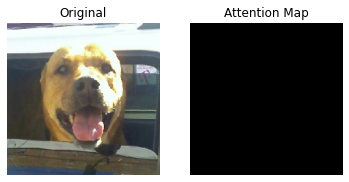

In [115]:
from vit_keras import vit, utils, visualize

imgs = next(validation_generator)

attention_map = visualize.attention_map(model=model3, image=imgs[0][6])

# Plot results
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.axis('off')
ax2.axis('off')
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(imgs[0][5])
_ = ax2.imshow(attention_map)

In [109]:
attention_map.max()

0

In [59]:
base_model.layers

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizers

import numpy as np
import math

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self):
    


class MultiHeadAttention(nn.Module):
    '''
    Multi-Head Attentionレイヤ
    
    hidden_dim : Embeddingされた単語ベクトルの長さ
    heads_num : マルチヘッドAttentionのヘッド数
       ※hidden_numはheads_numで割り切れえる値とすること
    drop_rate : 出力のDropout率

    model = MultiheadAttention(
        hidden_dim = 512,
        head_num = 8,
        drop_rate = 0.5
    )
    '''
    def __init__(self, token_num, hidden_dim, heads_num, drop_rate=0.5):
        super(MultiHeadAttention, self).__init__()
        # 入力の線形変換
        # 重み行列は[hidden_dim, hidden_dim]
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key   = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        
        # 出力の線形変換
        self.projection = nn.Linear(hidden_dim, hidden_dim)
        
        # 出力のDropout
        self.drop = nn.Dropout(drop_rate)
        
        self.nf = hidden_dim
        self.nh = heads_num
    
    def atten(self, query, key, value, attention_mask):
        """
        Attention
        
        query, key, value : 入力
        attention_mask : attention weight に適用される mask
        """
        # 各値を取得
        shape = query.shape
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[2] # トークン列数
        hidden_dim = shape[1]*shape[3] # 入力チャンネル数
        
        # ここで q と k の内積を取ることで、query と key の単語間の関連度のようなものを計算します。
        # tf.matmulで最後の2成分について積を計算(それ以外は形がそろっている必要あり)
        # transpose_bで転置
        # [token_num, hidden_dim/head_num] @ [hidden_dim/head_num, token_num] = [token_num, token_num]
        scores = torch.matmul(query, key.transpose(-2, -1))
        
        # scoreをhidden_dimの平方根割る
        scores = scores / math.sqrt(hidden_dim)
        
        # Attention Maskがあればscoreに加算
        # attention_mask: [batch_size, token_num, token_num] 
        # マスク(参照しない部分)の場所に1、使用する部分は0とする
        # 0の部分を -無限大にする(softmax(-無限大)=0となる)
        # 1. PADを無視
        # 2. DecoderのSelf-Attentionで未来の情報を参照できないようにする
        if attention_mask is not None:
            scores = scores.masked_fill(attention_mask == 1, -1e9)

        # softmax を取ることで正規化します
        # input(query) の各単語に対して memory(key) の各単語のどこから情報を引いてくるかの重み
        atten_weight = F.softmax(scores, dim = -1)
        #atten_weight = scores / torch.sum(scores, dim=-1, keepdim=True)
        
        # 重みに従って value から情報を引いてきます
        # [token_num, token_num] @ [token_num, hidden_dim/head_num] = [token_num, hidden_dim/head_num]
        # input(query) の単語ごとに memory(value)の各単語 に attention_weight を掛け合わせて足し合わせた ベクトル(分散表現の重み付き和)を計算
        context = torch.matmul(atten_weight, value)
        
        # 各ヘッドの結合(reshape)
        # 入力と同じ形に変換する
        context = context.transpose(1, 2).contiguous()
        context = context.view(batch_size, token_num, hidden_dim)
        
        # 線形変換
        context = self.projection(context)
        
        return self.drop(context), atten_weight

    def _split(self, x):
        """
        query, key, valueを分割する
        
        入力 shape: [batch_size, length, hidden_dim] の時
        出力 shape: [batch_size, head_num, length, hidden_dim//head_num]
        """
        # 各値を取得
        hidden_dim = self.nf
        heads_num = self.nh
        shape = x.shape
        batch_size = -1 if shape[0] is None else shape[0]
        token_num = shape[1] # トークン列数
        
        # [batch_size, token_num, hidden_dim] -> [batch_size, token_num, head_num, hidden_dim/head_num]
        # splitだが実際は次元を拡張する処理
        x = x.view(batch_size, token_num, heads_num, int(hidden_dim/heads_num))
        
        # [batch_size, token_num, head_num, hidden_dim/head_num] -> [batch_size, head_num, token_num, hidden_dim/head_num]
        x = x.transpose(1, 2)
        return x
    
    def forward(self, x, memory=None, attention_mask=None, return_attention_scores=False):
        """
        モデルの実行
        
        input : 入力(query) [batch_size, token_num, hidden_dim]
        memory : 入力(key, value) [batch_size, token_num, hidden_dim]
        attention_mask : attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 1 となるようなもの(Decoderで使用)
        """
        # memoryが入力されない場合、memory=input(Self Attention)とする
        if memory is None:
            memory = x
        
        # input -> query
        # memory -> key, value
        # [batch_size, token_num, hidden_dim] @ [hidden_dim, hidden_dim] -> [batch_size, token_num, hidden_dim] 
        query = self.query(x)
        key = self.key(memory)
        value = self.value(memory)
        
        # ヘッド数に分割する
        # 実際はreshapeで次数を1つ増やす
        # [batch_size, token_num, hidden_dim] -> [batch_size, head_num, token_num, hidden_dim/head_num]
        query = self._split(query)
        key = self._split(key)
        value = self._split(value)
        
        # attention
        # 入力と同じ形の出力
        # context: [batch_size, token_num, hidden_dim]
        # score_weightsはEncoderではNoneとする
        context, atten_weight = self.atten(query, key, value, attention_mask)
        
        if return_attention_scores:
            return context, atten_weight
        else:
            return context

class FeedForwardNetwork(nn.Module):
    '''
    Position-wise Feedforward Neural Network
    transformer blockで使用される全結合層
    '''
    def __init__(self, hidden_dim, drop_rate=0.1):
        super().__init__()
        # 2層構造
        # 1層目：チャンネル数を増加させる
        self.filter_dense_layer = nn.Linear(hidden_dim, hidden_dim * 4)
        self.relu1 = nn.ReLU()
        
        # 2層目：元のチャンネル数に戻す
        self.output_dense_layer = nn.Linear(hidden_dim * 4, hidden_dim)
        self.drop = nn.Dropout(drop_rate)

    def forward(self, x):
        '''
        入力と出力で形が変わらない
        [batch_size, token_num, hidden_dim]
        '''
        
        # [batch_size, token_num, hidden_dim] -> [batch_size, token_num, 4*hidden_dim]
        x = self.filter_dense_layer(x)
        x = self.relu1(x)
        x = self.drop(x)
        
        # [batch_size, token_num, 4*hidden_dim] -> [batch_size, token_num, hidden_dim]
        return self.output_dense_layer(x)

class ResidualNormalizationWrapper(nn.Module):
    '''
    残差接続
    output: input + SubLayer(input)
    '''
    def __init__(self, hidden_dim, layer, drop_rate=0.1):
        super().__init__()
        self.layer = layer # SubLayer : ここではAttentionかFFN
        self.layer_normalization = nn.LayerNorm(hidden_dim)
        self.drop = nn.Dropout(drop_rate)

    def forward(self, x, memory=None, attention_mask=None, return_attention_scores=False):
        """
        AttentionもFFNも入力と出力で形が変わらない
        [batch_size, token_num, hidden_dim]
        """
        
        params = {}
        if memory is not None:
            params['memory'] = memory
        if attention_mask is not None:
            params['attention_mask'] = attention_mask
        if return_attention_scores:
            params['return_attention_scores'] = return_attention_scores
        
        out = self.layer_normalization(x)
        if return_attention_scores:
            out, attn_weights = self.layer(out,**params)
            out = self.drop(out)
            return x + out, attn_weights
        else:
            out = self.layer(out,**params)
            out = self.drop(out)
            return x + out

class TransformerBlock(nn.Module):
    """
    transformer block : before ->[attention -> FF]-> next
    それぞれ残差接続とLayerNormalizationの処理が含まれる
    """
    def __init__(self, token_num, hidden_dim, heads_num, drop_rate=0.1):
        """
        hidden_numはheads_numで割り切れえる値とすること
        """
        super().__init__()
        self.atten = ResidualNormalizationWrapper(
            hidden_dim = hidden_dim,
            layer = MultiHeadAttention(token_num=token_num, hidden_dim = hidden_dim, heads_num = heads_num, drop_rate = drop_rate),
            drop_rate = drop_rate)
        
        self.ffn = ResidualNormalizationWrapper(
            hidden_dim = hidden_dim,
            layer = FeedForwardNetwork(hidden_dim = hidden_dim, drop_rate = drop_rate),
            drop_rate = drop_rate)
    
    def forward(self, input, memory=None, attention_mask=None, return_attention_scores=False):
        """
        入力と出力で形式が変わらない
        [batch_size, token_num, hidden_dim]
        """
        if return_attention_scores:
            x, attn_weights = self.atten(input, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x, attn_weights
        else:
            x = self.atten(input, memory, attention_mask, return_attention_scores)
            x = self.ffn(x)
            return x

class Encoder(nn.Module):
    '''
    TransformerのEncoder
    '''
    def __init__(
            self,
            vocab_size, # 単語の総数
            hopping_num, # Multi-head Attentionの繰り返し数
            heads_num, # Multi-head Attentionのヘッド数
            hidden_dim, # Embeddingの次数
            token_num, # 系列長(文章中のトークン数)
            drop_rate, # ドロップアウトの確率
            pretrained_weight=None
    ):
        super().__init__()
        self.hopping_num = hopping_num
        
        # Embedding層
        self.token_embedding = TokenEmbedding(vocab_size, hidden_dim, pretrained_weight)
        # Position Embedding
        self.add_position_embedding = AddPositionalEncoding()
        self.input_dropout_layer = nn.Dropout(drop_rate)

        # Multi-head Attentionの繰り返し(hopping)のリスト
        self.attention_block_list = nn.ModuleList([TransformerBlock(token_num, hidden_dim, heads_num) for _ in range(hopping_num)])
        self.output_normalization = nn.LayerNorm(hidden_dim)

    def forward(
            self,
            input,
            memory=None,
            attention_mask=None,
            return_attention_scores=False
    ):
        '''
        input: 入力 [batch_size, length]
        memory: 入力 [batch_size, length]
        attention_mask: attention weight に適用される mask
            [batch_size, 1, q_length, k_length] 
            pad 等無視する部分が 0 となるようなもの(Decoderで使用)
        出力 [batch_size, length, hidden_dim]
        '''
        # [batch_size, token_num] -> [batch_size, token_num, hidden_dim]
        embedded_input = self.token_embedding(input)
        # Positional Embedding
        embedded_input = self.add_position_embedding(embedded_input)
        query = self.input_dropout_layer(embedded_input)
        
        if return_attention_scores:
            # MultiHead Attentionを繰り返し適用
            for i in range(self.hopping_num):
                query, atten_weights = self.attention_block_list[i](query, memory, attention_mask, return_attention_scores)

            # [batch_size, token_num, hidden_dim]
            return self.output_normalization(query), atten_weights
        else:
            # MultiHead Attentionを繰り返し適用
            for i in range(self.hopping_num):
                query = self.attention_block_list[i](query, memory, attention_mask, return_attention_scores)

            # [batch_size, token_num, hidden_dim]
            return self.output_normalization(query)

class AttentionClassifier(nn.Module):
    def __init__(
            self,
            vocab_size, # 単語の総数
            hopping_num, # Multi-head Attentionの繰り返し数
            heads_num, # Multi-head Attentionのヘッド数
            hidden_dim, # Embeddingの次数
            token_num, # 系列長(文章中のトークン数)
            drop_rate, # ドロップアウトの確率
            NUMLABELS, # クラス数
            pretrained_weight=None,
            PAD_ID = 1
    ):
        super().__init__()
        self.PAD_ID = PAD_ID
        
        self.encoder = Encoder(vocab_size, hopping_num, heads_num, hidden_dim, token_num, drop_rate, pretrained_weight)
        self.dense1 = nn.Linear(hidden_dim, hidden_dim)
        self.act1 = nn.Tanh()
        self.dropout1 = nn.Dropout(drop_rate)   
        self.final_layer = nn.Linear(hidden_dim, NUMLABELS)
        
        nn.init.normal_(self.dense1.weight, std=0.02)
        nn.init.normal_(self.dense1.bias, std=0)
        nn.init.normal_(self.final_layer.weight, std=0.02)
        nn.init.normal_(self.final_layer.bias, std=0)

    def forward(self, x, return_attention_scores=False):
        self_attention_mask=self._create_enc_attention_mask(x)
        
        # [batch_size, token_num] -> [batch_size, token_num, hidden_dim]
        if return_attention_scores:
            enc_output, atten_weights = self.encoder(x, attention_mask=self_attention_mask,return_attention_scores=return_attention_scores)
        else:
            enc_output = self.encoder(x, attention_mask=self_attention_mask,return_attention_scores=return_attention_scores)
        
        # 文頭の重みを使用 [batch_size, 0, hidden_dim]
        # [batch_size, hidden_dim] -> [batch_size, hidden_dim]
        enc_output = self.dense1(enc_output[:, 0, :])
        enc_output = self.act1(enc_output)
        enc_output = self.dropout1(enc_output)
        
        # [batch_size, hidden_dim] -> [batch_size, NUMLABELS]
        final_output = self.final_layer(enc_output)

        if return_attention_scores:
            return final_output, atten_weights
        else:
            return final_output
    
    def _create_enc_attention_mask(self, x):
        batch_size, length = x.shape
        # マスクする部分を1とする
        pad_array = torch.eq(x, self.PAD_ID).to(dtype=torch.int8)  # [batch_size, token_num]
        
        # shape broadcasting で [batch_size, head_num, token_num, token_num] になる
        return pad_array.view([batch_size, 1, 1, length])